In [1]:
# USE 'BASE' ENVIRONMENT

import numpy as np
import pandas as pd
# from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import fisher_exact
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
input_path = r"../scores/taus/" + f'tau_0_05/scores_11_stocks_0_05_iter_1.csv'
df_1 = pd.read_csv(input_path, index_col = 0)
df_1

input_path = r"../scores/taus/" + f'tau_0_05/scores_11_stocks_0_05_iter_2.csv'
df_2 = pd.read_csv(input_path, index_col = 0)
df_2

df_concated = pd.concat([df_1, df_2])

df_concated

,clayton_random+gauss_dist+val,clayton_random+gauss_dist+score,clayton_random+t_dist+val,clayton_random+t_dist+scor,gaussian+gauss_dist+val,gaussian+gauss_dist+score,gaussian+t_dist+val,gaussian+t_dist+scor,t_student+gauss_dist+val,t_student+gauss_dist+score,t_student+t_dist+val,t_student+t_dist+scor
0,0.005712,0.000273,0.005414,0.000263,0.002106,0.000228,0.001827,0.000219,0.001616,0.000215,0.001418,0.000208
1,0.003400,0.000282,0.003240,0.000261,0.000979,0.000240,0.000806,0.000220,0.000525,0.000219,0.000433,0.000202
2,0.003057,0.000332,0.002739,0.000311,0.000068,0.000290,-0.000181,0.000271,0.000017,0.000267,-0.000170,0.000250
3,0.001699,0.000354,0.001528,0.000330,-0.000568,0.000326,-0.000586,0.000306,-0.000823,0.000321,-0.000798,0.000302
4,0.002083,0.000397,0.001678,0.000365,-0.000713,0.000352,-0.000860,0.000328,-0.000903,0.000338,-0.001011,0.000316
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.001238,0.000514,0.001052,0.000514,-0.000256,0.000520,-0.000433,0.000519,-0.000529,0.000493,-0.000679,0.000493
60,0.001016,0.000518,0.000759,0.000521,-0.000204,0.000513,-0.000450,0.000516,-0.000257,0.000495,-0.000479,0.000499
61,0.000819,0.000507,0.000612,0.000510,-0.000510,0.000505,-0.000719,0.000508,-0.000382,0.000504,-0.000569,0.000507
62,0.001510,0.000538,0.001193,0.000542,-0.000338,0.000531,-0.000640,0.000534,-0.000388,0.000505,-0.000646,0.000509


In [3]:
def get_taus_complex_models_scores(taus):
    scores = {}
    for tau in taus:
        tau_dfs_list = []
        for iter in range(1, 11):
            tau_str = str(tau).replace(".", "_")
            input_path = r"../scores/taus/" + f'tau_{tau_str}/scores_11_stocks_{tau_str}_iter_{iter}.csv'
            df = pd.read_csv(input_path, index_col = 0)
            tau_dfs_list.append(df)
        concatenated_df = pd.concat(tau_dfs_list)
        scores[tau] = concatenated_df
    return scores

def get_multivariate_scores_dfs(taus):
    scores = {}
    for tau in taus:
        tau_dfs_list = []
        for iter in range(1, 11):
            tau_str = str(tau).replace(".", "_")
            input_path = r"multivariate_scores/taus/" + f'tau_{tau_str}/multivariate_dists_scores_11_stocks_{tau_str}_iter_{iter}.csv'
            df = pd.read_csv(input_path, index_col = 0)
            tau_dfs_list.append(df)
        concatenated_df = pd.concat(tau_dfs_list)
        scores[tau] = concatenated_df
    return scores


def get_interval_test_result(data, test_type, bounds):
    val_columns = [col for col in data.columns if "val" in col]

    results = []
    for col in val_columns:

        percentile_2_5 = data[col].quantile(0.025)
        percentile_97_5 = data[col].quantile(0.975)
        percentile_5 = data[col].quantile(0.05)
        percentile_95 = data[col].quantile(0.95)

        if test_type == "two-sided" and ((percentile_2_5 >= bounds[0]) & (percentile_97_5 <= bounds[1])):
            reject_h0 = False
        elif test_type == "lower" and (percentile_5 >= bounds[0]):
            reject_h0 = False
        elif test_type == "upper" and (percentile_95 <= bounds[0]):
            reject_h0 = False
        else:
            reject_h0 = True

        results.append({
            "Column": col,
            "Percentile 2.5": percentile_2_5,
            "Percentile 97.5": percentile_97_5,
            "Reject H0": reject_h0
        })
    results_df = pd.DataFrame(results)
    return results_df


def get_bounds_from_gaussian_dist(taus, multivariate_scores):
    taus_dict = {}
    for tau in taus:
        gauss_scores = multivariate_scores[tau]["gauss_dist+val"]
        lower_bound = gauss_scores.quantile(0.025)
        upper_bound = gauss_scores.quantile(0.975)
        taus_dict[tau] = (lower_bound, upper_bound)
    return taus_dict


In [27]:
taus = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]

scores = get_taus_complex_models_scores(taus)
multivariate_scores = get_multivariate_scores_dfs(taus)
bounds_dict = get_bounds_from_gaussian_dist(taus, multivariate_scores)

a, b = -0.004, 0.004
# p_value_threshold = 0.05
coeff = 0.0


for tau in taus:
    tau_score = scores[tau]
    # results = get_test_results(tau_score, a, b, p_value_threshold)

    multivariate_tau_score = multivariate_scores[tau]
    # multivariate_results = get_interval_test_result(multivariate_tau_score, "two-sided", (a * coeff, b * coeff))
    multivariate_results = get_interval_test_result(multivariate_tau_score, "lower", [a * coeff])
    # multivariate_results = get_interval_test_result(multivariate_tau_score, "upper", [b * coeff])

    lower_bound, upper_bound = bounds_dict[tau]


    # results = get_interval_test_result(tau_score, "two-sided", (a * coeff, b * coeff))
    results = get_interval_test_result(tau_score, "lower", [a * coeff])
    # results = get_interval_test_result(tau_score, "upper", [b * coeff])


    print(f"Tau: {tau}\n")
    # print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}\n")
    print(f"Lower bound: {a}, Upper bound: {b}\n")

    print(results)
    print("\n")
    print(multivariate_results)
    print("\n")






Tau: 0.0005

Lower bound: -0.004, Upper bound: 0.004

                          Column  Percentile 2.5  Percentile 97.5  Reject H0
0  clayton_random+gauss_dist+val       -0.000036         0.005631      False
1      clayton_random+t_dist+val       -0.000036         0.004878      False
2        gaussian+gauss_dist+val       -0.000081         0.002742       True
3            gaussian+t_dist+val       -0.000081         0.002190       True
4       t_student+gauss_dist+val       -0.000068         0.002795      False
5           t_student+t_dist+val       -0.000068         0.002310      False


           Column  Percentile 2.5  Percentile 97.5  Reject H0
0  gauss_dist+val        0.000149         0.003930      False
1      t_dist+val        0.002826         0.010869      False


Tau: 0.001

Lower bound: -0.004, Upper bound: 0.004

                          Column  Percentile 2.5  Percentile 97.5  Reject H0
0  clayton_random+gauss_dist+val       -0.000107         0.005583      False
1      cla

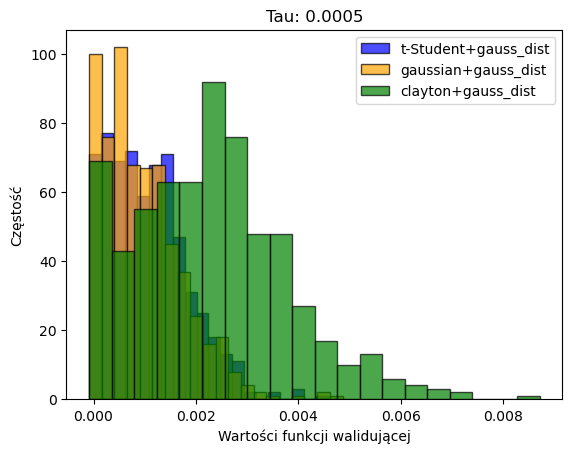

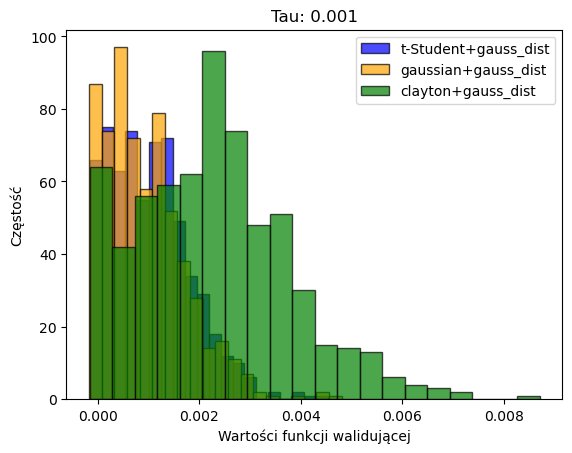

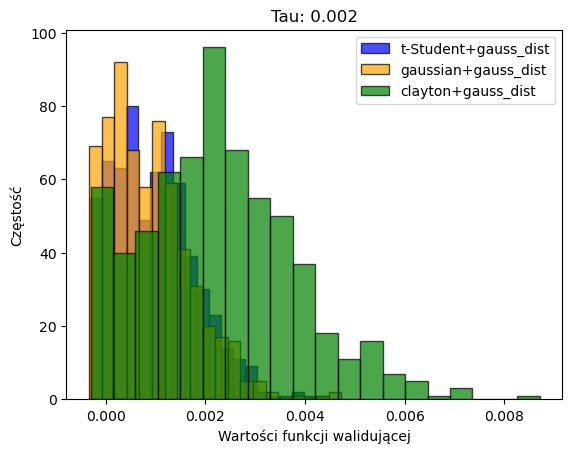

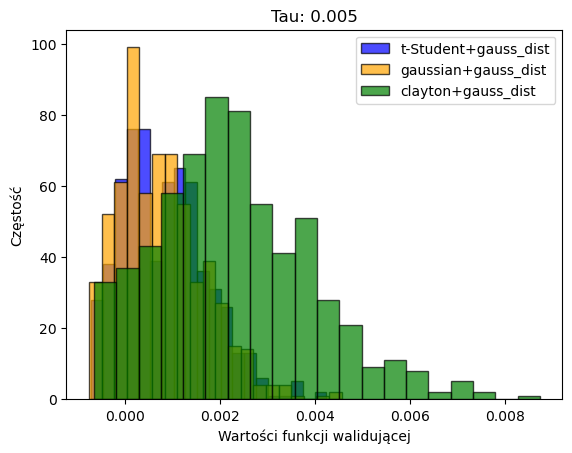

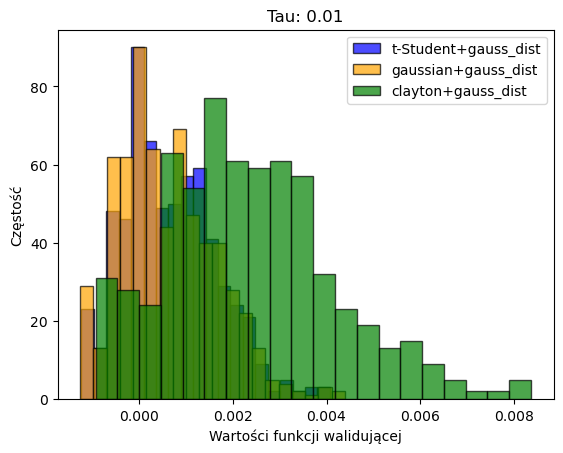

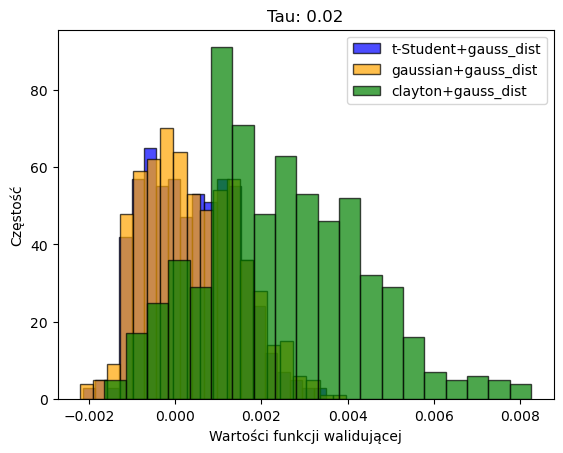

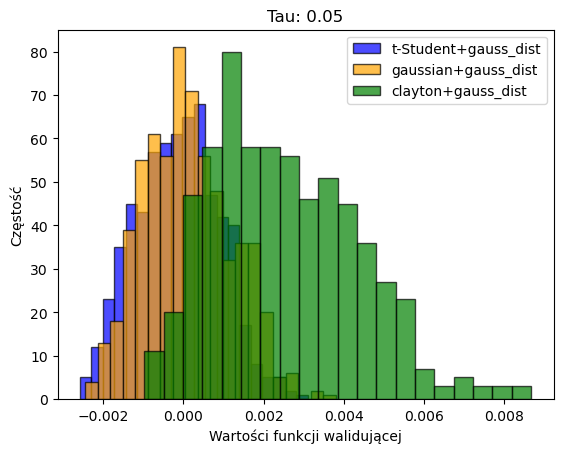

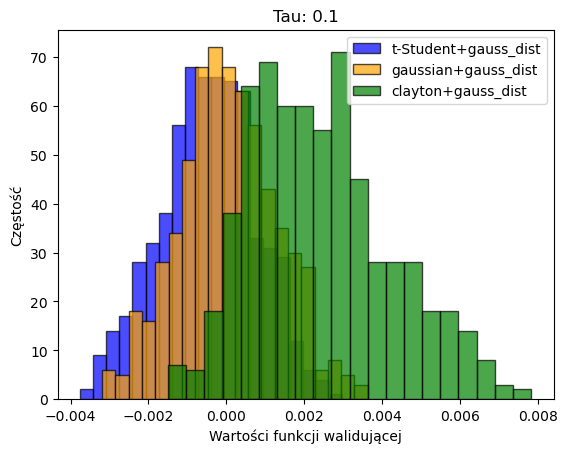

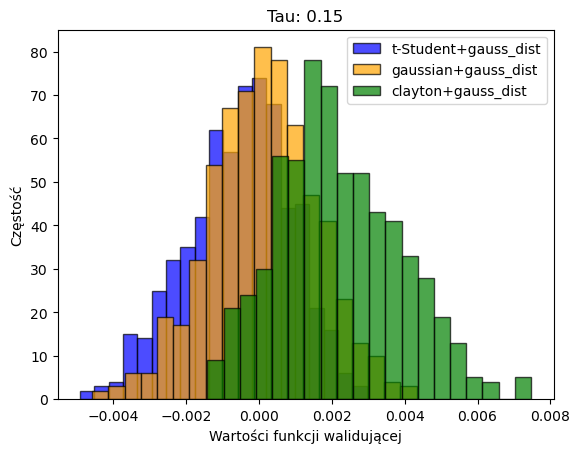

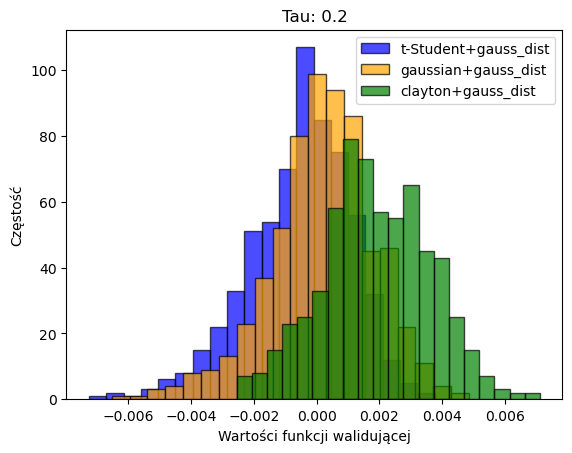

In [6]:
for tau in taus:
    plt.hist(scores[tau]["t_student+gauss_dist+val"], bins=20, alpha=0.7, label="t-Student+gauss_dist", color='blue', edgecolor='black')
    plt.hist(scores[tau]["gaussian+gauss_dist+val"], bins=20, alpha=0.7, label="gaussian+gauss_dist", color='orange', edgecolor='black')
    plt.hist(scores[tau]["clayton_random+gauss_dist+val"], bins=20, alpha=0.7, label="clayton+gauss_dist", color='green', edgecolor='black')

    plt.title(f'Tau: {tau}')
    plt.xlabel("Wartości funkcji walidującej")
    plt.ylabel("Częstość")
    plt.legend()
    plt.show()

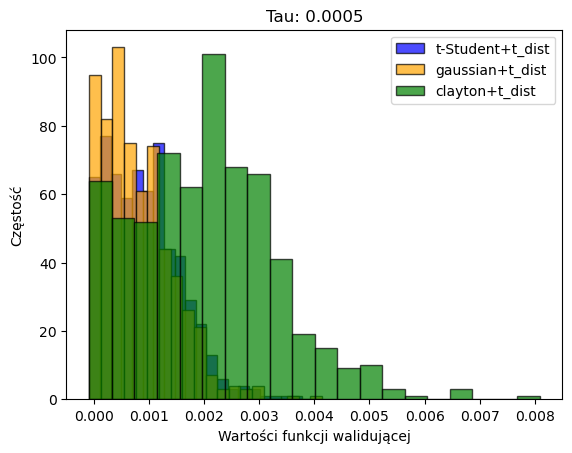

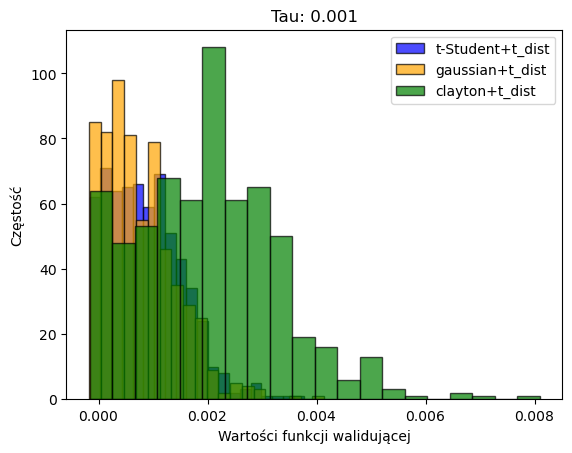

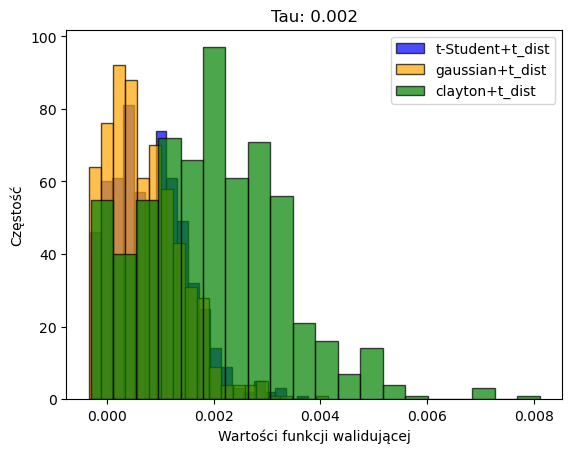

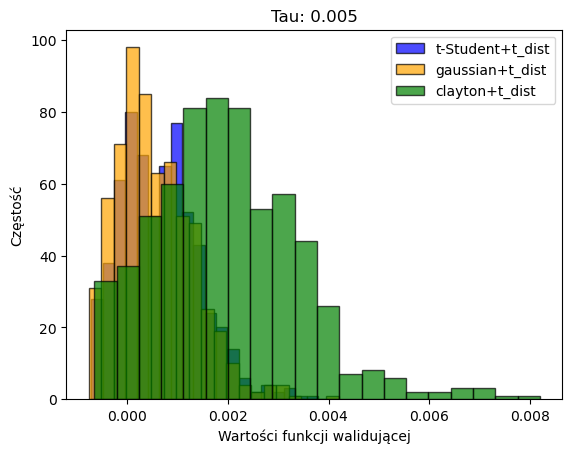

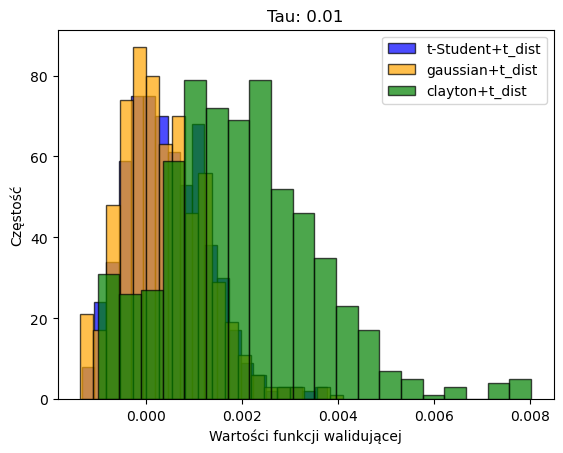

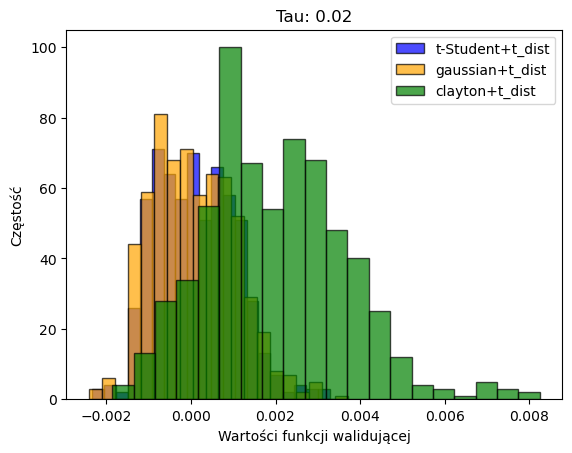

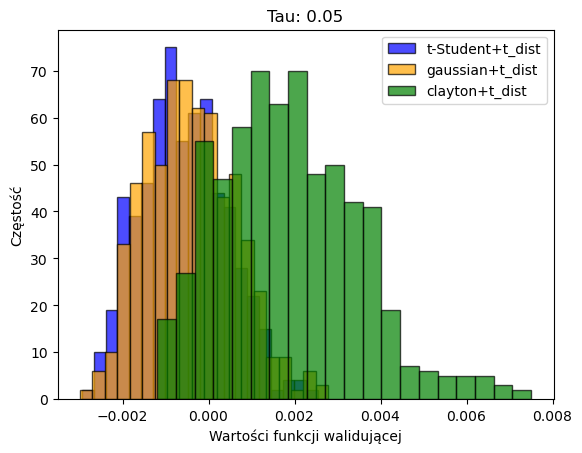

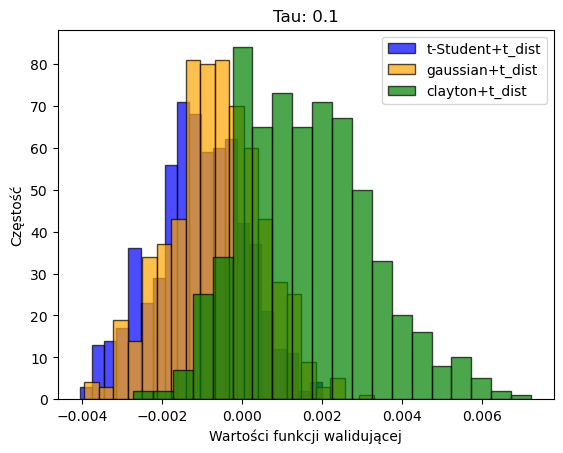

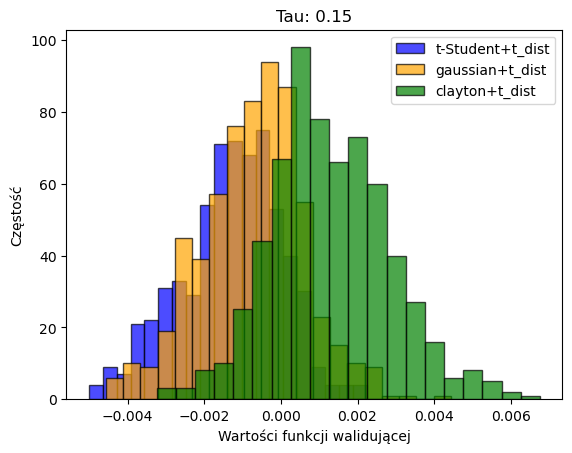

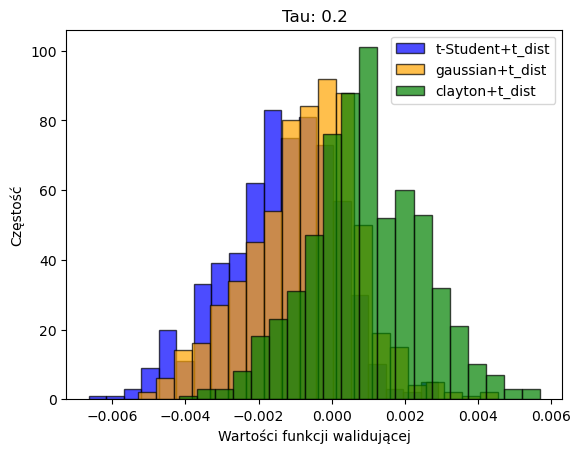

In [7]:
for tau in taus:
    plt.hist(scores[tau]["t_student+t_dist+val"], bins=20, alpha=0.7, label="t-Student+t_dist", color='blue', edgecolor='black')
    plt.hist(scores[tau]["gaussian+t_dist+val"], bins=20, alpha=0.7, label="gaussian+t_dist", color='orange', edgecolor='black')
    plt.hist(scores[tau]["clayton_random+t_dist+val"], bins=20, alpha=0.7, label="clayton+t_dist", color='green', edgecolor='black')

    plt.title(f'Tau: {tau}')
    plt.xlabel("Wartości funkcji walidującej")
    plt.ylabel("Częstość")
    plt.legend()
    plt.show()

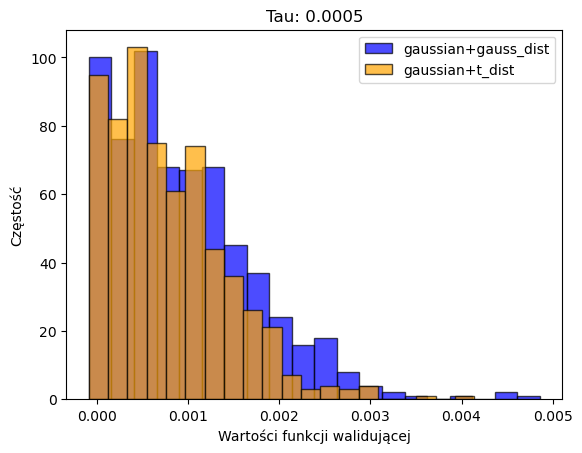

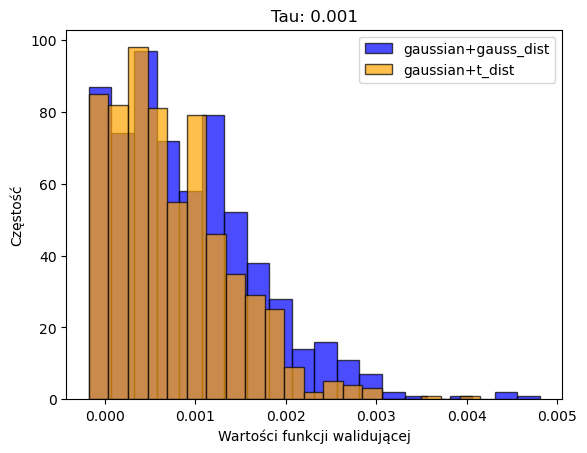

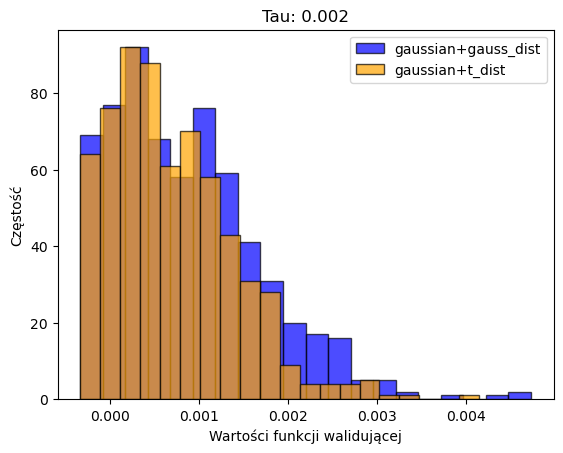

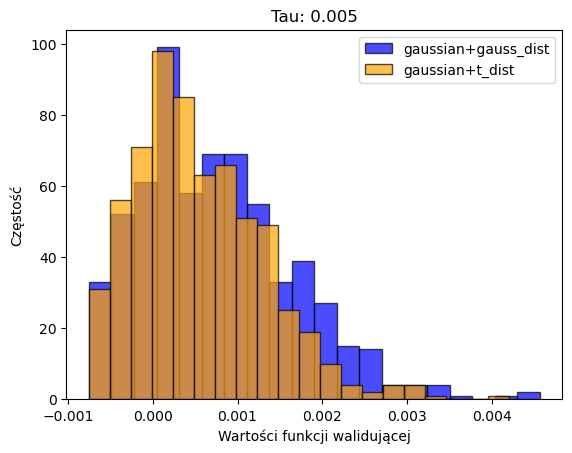

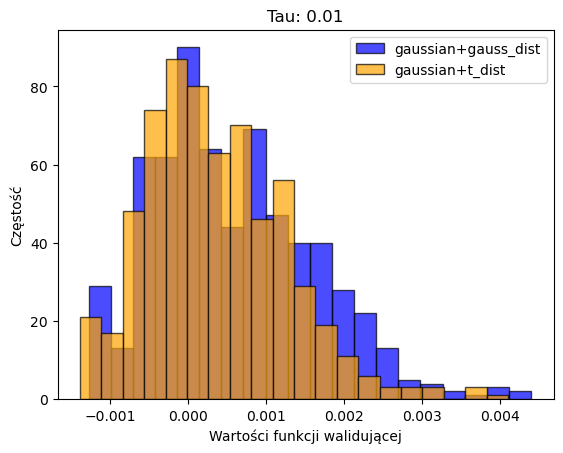

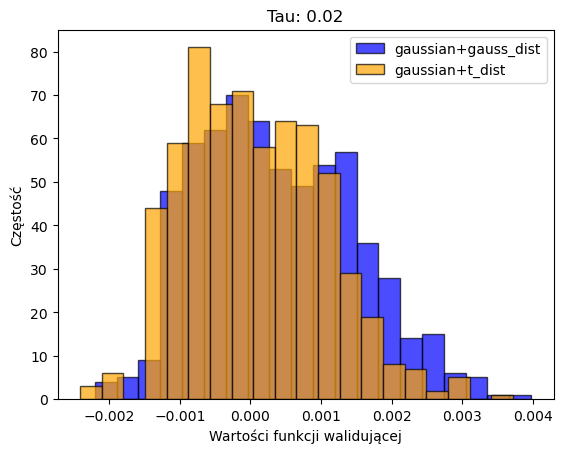

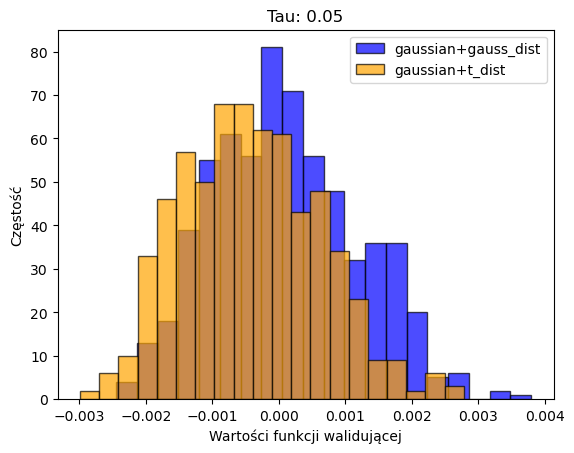

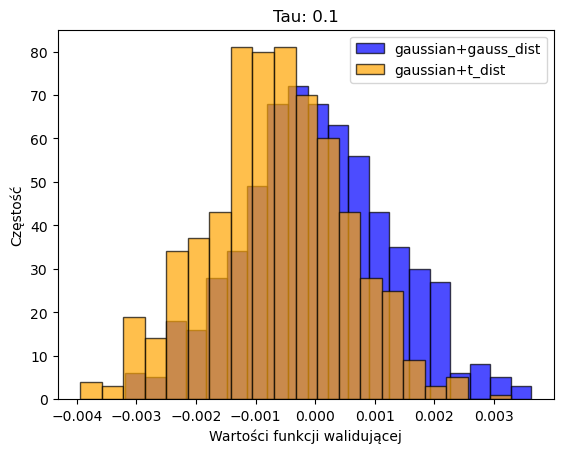

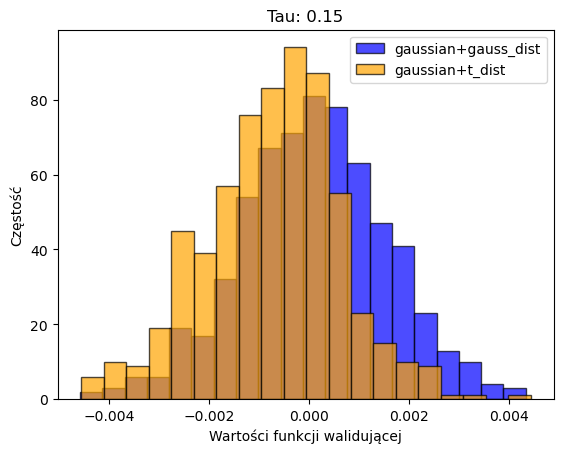

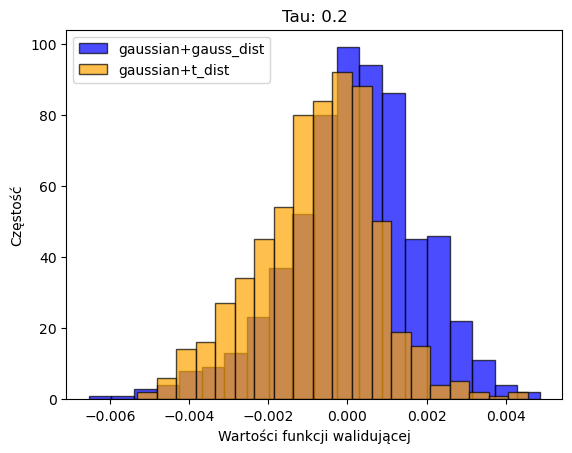

In [8]:
for tau in taus:
    plt.hist(scores[tau]["gaussian+gauss_dist+val"], bins=20, alpha=0.7, label="gaussian+gauss_dist", color='blue', edgecolor='black')
    plt.hist(scores[tau]["gaussian+t_dist+val"], bins=20, alpha=0.7, label="gaussian+t_dist", color='orange', edgecolor='black')
    # plt.hist(scores[tau]["clayton_random+t_dist+val"], bins=20, alpha=0.7, label="clayton+t_dist", color='green', edgecolor='black')

    plt.title(f'Tau: {tau}')
    plt.xlabel("Wartości funkcji walidującej")
    plt.ylabel("Częstość")
    plt.legend()
    plt.show()

In [25]:

def get_models_df(taus, test_type, bounds):
    complex_model_results = []
    multivariate_model_results = []
    for tau in taus:
        tau_score = scores[tau]
        results = get_interval_test_result(tau_score, test_type, bounds)
        results["Tau"] = tau
        complex_model_results.append(results)

        multivariate_tau_score = multivariate_scores[tau]
        multivariate_results = get_interval_test_result(multivariate_tau_score, test_type, bounds)
        multivariate_results["Tau"] = tau
        multivariate_model_results.append(multivariate_results)
    complex_model_df = pd.concat(complex_model_results, ignore_index=True)
    multivariate_model_df = pd.concat(multivariate_model_results, ignore_index=True)
    return complex_model_df, multivariate_model_df

def summarize_results_with_totals(df, model_type):
    counts = (
        df[df["Reject H0"] == False]
        .groupby(["Tau", "Column"])
        .size()
        .reset_index(name="Count")
    )

    all_models = df["Column"].unique()
    all_taus = df["Tau"].unique()
    full_index = pd.MultiIndex.from_product(
        [all_taus, all_models],
        names=["Tau", "Column"]
    )
    counts = counts.set_index(["Tau", "Column"]).reindex(full_index, fill_value=0).reset_index()
    total_counts = counts.groupby("Column")["Count"].sum().reset_index(name="Total Count")

    total_counts["Model Type"] = model_type
    return total_counts




In [24]:
coeff = 1.0
a, b = -0.004 * coeff, 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "two-sided", (a, b))
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,1,Complex Models
2,gaussian+gauss_dist+val,10,Complex Models
3,gaussian+t_dist+val,9,Complex Models
4,t_student+gauss_dist+val,9,Complex Models
5,t_student+t_dist+val,8,Complex Models
6,gauss_dist+val,4,Multivariate Models
7,t_dist+val,0,Multivariate Models


In [25]:
coeff = 0.9
a, b = -0.004 * coeff, 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "two-sided", (a, b))
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,0,Complex Models
2,gaussian+gauss_dist+val,9,Complex Models
3,gaussian+t_dist+val,8,Complex Models
4,t_student+gauss_dist+val,9,Complex Models
5,t_student+t_dist+val,8,Complex Models
6,gauss_dist+val,0,Multivariate Models
7,t_dist+val,0,Multivariate Models


In [28]:
coeff = 0.8
a, b = -0.004 * coeff, 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "two-sided", (a, b))
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,0,Complex Models
2,gaussian+gauss_dist+val,9,Complex Models
3,gaussian+t_dist+val,8,Complex Models
4,t_student+gauss_dist+val,8,Complex Models
5,t_student+t_dist+val,7,Complex Models
6,gauss_dist+val,0,Multivariate Models
7,t_dist+val,0,Multivariate Models


In [29]:
coeff = 0.7
a, b = -0.004 * coeff, 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "two-sided", (a, b))
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,0,Complex Models
2,gaussian+gauss_dist+val,8,Complex Models
3,gaussian+t_dist+val,7,Complex Models
4,t_student+gauss_dist+val,5,Complex Models
5,t_student+t_dist+val,7,Complex Models
6,gauss_dist+val,0,Multivariate Models
7,t_dist+val,0,Multivariate Models


In [ ]:
coeff = 0.6
a, b = -0.004 * coeff, 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "two-sided", (a, b))
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,0,Complex Models
2,gaussian+gauss_dist+val,0,Complex Models
3,gaussian+t_dist+val,0,Complex Models
4,t_student+gauss_dist+val,0,Complex Models
5,t_student+t_dist+val,1,Complex Models
6,gauss_dist+val,0,Multivariate Models
7,t_dist+val,0,Multivariate Models


In [49]:
coeff = 1.0
a = -0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "lower", [a])
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,10,Complex Models
1,clayton_random+t_dist+val,10,Complex Models
2,gaussian+gauss_dist+val,10,Complex Models
3,gaussian+t_dist+val,10,Complex Models
4,t_student+gauss_dist+val,10,Complex Models
5,t_student+t_dist+val,9,Complex Models
6,gauss_dist+val,10,Multivariate Models
7,t_dist+val,10,Multivariate Models


In [51]:
coeff = 0.8
a = -0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "lower", [a])
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,10,Complex Models
1,clayton_random+t_dist+val,10,Complex Models
2,gaussian+gauss_dist+val,10,Complex Models
3,gaussian+t_dist+val,9,Complex Models
4,t_student+gauss_dist+val,9,Complex Models
5,t_student+t_dist+val,8,Complex Models
6,gauss_dist+val,10,Multivariate Models
7,t_dist+val,10,Multivariate Models


In [26]:
coeff = 0.6
a = -0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "lower", [a])
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,10,Complex Models
1,clayton_random+t_dist+val,10,Complex Models
2,gaussian+gauss_dist+val,8,Complex Models
3,gaussian+t_dist+val,7,Complex Models
4,t_student+gauss_dist+val,7,Complex Models
5,t_student+t_dist+val,7,Complex Models
6,gauss_dist+val,10,Multivariate Models
7,t_dist+val,10,Multivariate Models


In [60]:
coeff = 0.0
a = -0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "lower", [a])
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,3,Complex Models
1,clayton_random+t_dist+val,2,Complex Models
2,gaussian+gauss_dist+val,0,Complex Models
3,gaussian+t_dist+val,0,Complex Models
4,t_student+gauss_dist+val,1,Complex Models
5,t_student+t_dist+val,1,Complex Models
6,gauss_dist+val,3,Multivariate Models
7,t_dist+val,10,Multivariate Models


In [ ]:
coeff = 1.0
a = 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "upper", [a])
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,1,Complex Models
2,gaussian+gauss_dist+val,10,Complex Models
3,gaussian+t_dist+val,10,Complex Models
4,t_student+gauss_dist+val,10,Complex Models
5,t_student+t_dist+val,10,Complex Models
6,gauss_dist+val,10,Multivariate Models
7,t_dist+val,0,Multivariate Models


In [48]:
coeff = 0.9
a = 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "upper", [a])
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,1,Complex Models
2,gaussian+gauss_dist+val,10,Complex Models
3,gaussian+t_dist+val,10,Complex Models
4,t_student+gauss_dist+val,10,Complex Models
5,t_student+t_dist+val,10,Complex Models
6,gauss_dist+val,9,Multivariate Models
7,t_dist+val,0,Multivariate Models


In [41]:
coeff = 0.7
a = 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "upper", [a])
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,0,Complex Models
2,gaussian+gauss_dist+val,10,Complex Models
3,gaussian+t_dist+val,10,Complex Models
4,t_student+gauss_dist+val,10,Complex Models
5,t_student+t_dist+val,10,Complex Models
6,gauss_dist+val,0,Multivariate Models
7,t_dist+val,0,Multivariate Models


In [43]:
coeff = 0.6
a = 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "upper", [a])
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,0,Complex Models
2,gaussian+gauss_dist+val,6,Complex Models
3,gaussian+t_dist+val,10,Complex Models
4,t_student+gauss_dist+val,6,Complex Models
5,t_student+t_dist+val,10,Complex Models
6,gauss_dist+val,0,Multivariate Models
7,t_dist+val,0,Multivariate Models


In [41]:
coeff = 0.6
a = 0.004 * coeff

complex_model_df, multivariate_model_df = get_models_df(taus, "upper", [a])
complex_model_summary = summarize_results_with_totals(complex_model_df, "Complex Models")
multivariate_model_summary = summarize_results_with_totals(multivariate_model_df, "Multivariate Models")


final_summary = pd.concat([complex_model_summary, multivariate_model_summary], ignore_index=True)
final_summary

,Column,Total Count,Model Type
0,clayton_random+gauss_dist+val,0,Complex Models
1,clayton_random+t_dist+val,0,Complex Models
2,gaussian+gauss_dist+val,6,Complex Models
3,gaussian+t_dist+val,10,Complex Models
4,t_student+gauss_dist+val,6,Complex Models
5,t_student+t_dist+val,10,Complex Models
6,gauss_dist+val,0,Multivariate Models
7,t_dist+val,0,Multivariate Models
